#### Grouping Using K means Clustering and Random Features

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Tickers list
tickers = [
    "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD",
    "ADA-USD", "DOGE-USD", "AVAX-USD", "DOT-USD", "MATIC-USD",
    "SHIB-USD", "TRX-USD", "LTC-USD", "LINK-USD", "XLM-USD",
    "APT-USD", "INJ-USD", "OP-USD"
]




# Download historical data
def get_crypto_data(tickers, start="2024-07-01", end="2025-07-20"):
    return yf.download(tickers, start=start, end=end, group_by='ticker', interval="1d", auto_adjust=False)

raw_data = get_crypto_data(tickers)

# Feature extraction
feature_dict = {}

for ticker in tickers:
    try:
        df = raw_data[ticker].copy()
        df.dropna(inplace=True)

        # Daily percentage change
        df["Daily % Change"] = df["Close"].pct_change() * 100

        # Volatility (std of daily returns)
        volatility = df["Daily % Change"].std()

        # Rate of Change (10-day)
        df["ROC"] = df["Close"].pct_change(periods=10) * 100
        roc_mean = df["ROC"].mean()

        # RSI (14-day)
        delta = df["Close"].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        avg_rsi = rsi.mean()

        # Average volume
        avg_volume = df["Volume"].mean()

        feature_dict[ticker] = {
            "Daily % Change": df["Daily % Change"].mean(),
            "Volatility": volatility,
            "ROC": roc_mean,
            "RSI": avg_rsi,
            "Volume": avg_volume
        }

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Create DataFrame
features = pd.DataFrame(feature_dict).T.dropna()

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# KMeans Clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
features["Cluster"] = kmeans.fit_predict(X_scaled)

# # 2D Visualization using first 2 features
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=features, x="Daily % Change", y="Volatility", hue="Cluster", palette="Set2", s=100)
# for i in features.index:
#     plt.text(features.loc[i, "Daily % Change"], features.loc[i, "Volatility"], i, fontsize=9)
# plt.title("K-Means Clustering of Cryptos (Daily % Change vs Volatility)")
# plt.grid(True)
# # plt.show()

# Print cluster members
for i in range(k):
    print(f"\nCluster {i}:")
    print(features[features["Cluster"] == i].index.tolist())


[*********************100%***********************]  15 of 15 completed



Cluster 0:
['ADA-USD', 'DOGE-USD', 'TRX-USD', 'LTC-USD', 'LINK-USD', 'XLM-USD']

Cluster 1:
['BNB-USD', 'SOL-USD']

Cluster 2:
['AVAX-USD', 'DOT-USD', 'MATIC-USD', 'SHIB-USD', 'APT-USD', 'INJ-USD', 'OP-USD']


#### Clustering using K means and Cointegrated features`

C:\Users\luvra\AppData\Local\Temp\ipykernel_11780\948588451.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  18 of 18 completed
C:\Users\luvra\AppData\Local\Temp\ipykernel_11780\948588451.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(features_df.PC1[i] + 0.02, features_df.PC2[i] + 0.02, symbol, fontsize=9)


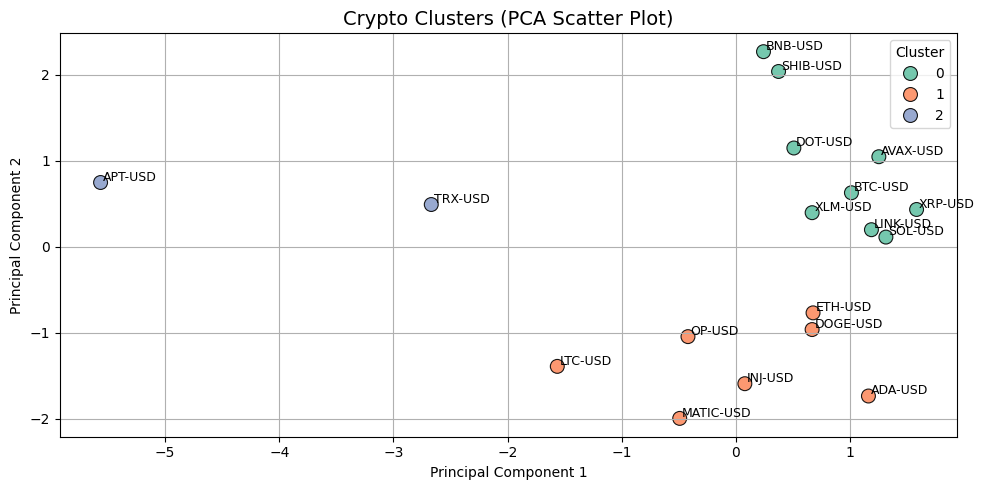

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define crypto tickers ---
crypto_symbols = [
    "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD",
    "ADA-USD", "DOGE-USD", "AVAX-USD", "DOT-USD", "MATIC-USD",
    "SHIB-USD", "TRX-USD", "LTC-USD", "LINK-USD", "XLM-USD",
    "APT-USD", "INJ-USD", "OP-USD"
]

# --- Step 2: Download price data using 'Close' ---
def download_price_data(tickers, start="2024-07-01", end="2025-07-01"):
    price_df = yf.download(tickers, start=start, end=end)['Close']
    return price_df.dropna()

price_data = download_price_data(crypto_symbols)

# --- Step 3: Feature Engineering ---
def generate_features(df):
    log_returns = np.log(df / df.shift(1))
    vol_30d = log_returns.rolling(30).std()
    ma_30d = df.rolling(30).mean()
    zscore_price = (df - ma_30d) / df.rolling(30).std()
    price_to_ma = df / ma_30d

    # Correlation with BTC and ETH
    btc_corr = log_returns.rolling(30).corr(log_returns['BTC-USD'])
    eth_corr = log_returns.rolling(30).corr(log_returns['ETH-USD'])

    # Final feature DataFrame
    features = pd.DataFrame({
        'volatility': vol_30d.iloc[-1],
        'price_to_ma': price_to_ma.iloc[-1],
        'zscore': zscore_price.iloc[-1],
        'btc_corr': btc_corr.iloc[-1],
        'eth_corr': eth_corr.iloc[-1]
    })
    return features.dropna()

features_df = generate_features(price_data)

# --- Step 4: Scale Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

# --- Step 5: K-Means Clustering ---
k = 3  # Change depending on use case
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)

# --- Step 6: Append Clusters to Feature Data ---
features_df['Cluster'] = clusters

from sklearn.decomposition import PCA

# --- Step 7a: Reduce to 2D using PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Add PCA result to DataFrame
features_df['PC1'] = pca_result[:, 0]
features_df['PC2'] = pca_result[:, 1]

# --- Step 7b: Scatter Plot ---
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=features_df,
    x='PC1', y='PC2',
    hue='Cluster',
    palette='Set2',
    s=100,
    alpha=0.9,
    edgecolor='black'
)

for i, symbol in enumerate(features_df.index):
    plt.text(features_df.PC1[i] + 0.02, features_df.PC2[i] + 0.02, symbol, fontsize=9)

plt.title('Crypto Clusters (PCA Scatter Plot)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()



In [13]:
from statsmodels.tsa.stattools import coint
from itertools import combinations

# --- Step 8: Cointegration test within each cluster ---
def test_cointegration(price_data, cluster_df):
    results = []
    for cluster_id in sorted(cluster_df['Cluster'].unique()):
        cluster_members = cluster_df[cluster_df['Cluster'] == cluster_id].index.tolist()
        print(f"\nCluster {cluster_id} pairs:")

        for sym1, sym2 in combinations(cluster_members, 2):
            series1 = price_data[sym1]
            series2 = price_data[sym2]

            score, pvalue, _ = coint(series1, series2)
            results.append((cluster_id, sym1, sym2, pvalue))

            print(f"{sym1} vs {sym2}: p-value = {pvalue:.4f} {'< 0.05 ✓' if pvalue < 0.05 else ''}")
    
    return pd.DataFrame(results, columns=['Cluster', 'Crypto1', 'Crypto2', 'PValue'])

cointegration_results = test_cointegration(price_data, features_df)



Cluster 0 pairs:
AVAX-USD vs BNB-USD: p-value = 0.8414 
AVAX-USD vs BTC-USD: p-value = 0.7600 
AVAX-USD vs DOT-USD: p-value = 0.4974 
AVAX-USD vs LINK-USD: p-value = 0.8781 
AVAX-USD vs SHIB-USD: p-value = 0.1258 
AVAX-USD vs SOL-USD: p-value = 0.2438 
AVAX-USD vs XLM-USD: p-value = 0.6601 
AVAX-USD vs XRP-USD: p-value = 0.8969 
BNB-USD vs BTC-USD: p-value = 0.0082 < 0.05 ✓
BNB-USD vs DOT-USD: p-value = 0.4106 
BNB-USD vs LINK-USD: p-value = 0.0137 < 0.05 ✓
BNB-USD vs SHIB-USD: p-value = 0.4448 
BNB-USD vs SOL-USD: p-value = 0.2745 
BNB-USD vs XLM-USD: p-value = 0.0072 < 0.05 ✓
BNB-USD vs XRP-USD: p-value = 0.0475 < 0.05 ✓
BTC-USD vs DOT-USD: p-value = 0.6844 
BTC-USD vs LINK-USD: p-value = 0.1952 
BTC-USD vs SHIB-USD: p-value = 0.8925 
BTC-USD vs SOL-USD: p-value = 0.9113 
BTC-USD vs XLM-USD: p-value = 0.0012 < 0.05 ✓
BTC-USD vs XRP-USD: p-value = 0.5100 
DOT-USD vs LINK-USD: p-value = 0.2806 
DOT-USD vs SHIB-USD: p-value = 0.2340 
DOT-USD vs SOL-USD: p-value = 0.3550 
DOT-USD vs XLM

#### Grouping using Correlation

In [4]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import coint  # <-- Import cointegration test

tickers = [
    "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD",
    "ADA-USD", "DOGE-USD", "AVAX-USD", "DOT-USD", "MATIC-USD",
    "SHIB-USD", "TRX-USD", "LTC-USD", "LINK-USD", "XLM-USD",
    "APT-USD", "INJ-USD", "OP-USD"
]

# Download data
def get_crypto_data(tickers, start="2024-07-01", end="2025-07-20"):
    return yf.download(tickers, start=start, end=end, group_by='ticker', interval="1d", auto_adjust=False)

raw_data = get_crypto_data(tickers)

# Extract Close prices
close_prices = pd.DataFrame({ticker: raw_data[ticker]['Close'] for ticker in tickers})
daily_returns = close_prices.pct_change().dropna()

# Limit to avoid too many plots
top_n_pairs = 49

# Compute correlation matrix
corr_matrix = daily_returns.corr()

# Get all ticker pairs with correlation values
pairs = []
for (a, b) in itertools.combinations(tickers, 2):
    corr = corr_matrix.loc[a, b]
    pairs.append(((a, b), corr))

# Sort by absolute correlation
sorted_pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)[:top_n_pairs]

# Plot scatter plots with cointegration results
for (ticker1, ticker2), corr_value in sorted_pairs:
    series1 = close_prices[ticker1].dropna()
    series2 = close_prices[ticker2].dropna()

    # Align the series (important for cointegration)
    combined = pd.concat([series1, series2], axis=1).dropna()
    s1, s2 = combined[ticker1], combined[ticker2]

    # Run cointegration test
    coint_score, pvalue, _ = coint(s1, s2)

    # Print both correlation and cointegration info
    print(f"\n{ticker1} vs {ticker2}")
    print(f"  Correlation: {corr_value:.4f}")
    print(f"  Cointegration p-value: {pvalue:.4f}")

    # # Plot scatter
    # plt.figure(figsize=(6, 5))
    # sns.scatterplot(x=daily_returns[ticker1], y=daily_returns[ticker2], alpha=0.6)
    # plt.title(f"{ticker1} vs {ticker2} Returns\nCorr: {corr_value:.2f} | Coint p: {pvalue:.4f}")
    # plt.xlabel(f"{ticker1} Daily Return")
    # plt.ylabel(f"{ticker2} Daily Return")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    # plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    # plt.show()


[*********************100%***********************]  18 of 18 completed
C:\Users\luvra\AppData\Local\Temp\ipykernel_7528\1051714599.py:23: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = close_prices.pct_change().dropna()



AVAX-USD vs LINK-USD
  Correlation: 0.8417
  Cointegration p-value: 0.8451

AVAX-USD vs INJ-USD
  Correlation: 0.8117
  Cointegration p-value: 0.6340

ETH-USD vs OP-USD
  Correlation: 0.8101
  Cointegration p-value: 0.9853

AVAX-USD vs OP-USD
  Correlation: 0.8042
  Cointegration p-value: 0.6619

BTC-USD vs DOGE-USD
  Correlation: 0.8013
  Cointegration p-value: 0.9818

BTC-USD vs ETH-USD
  Correlation: 0.8003
  Cointegration p-value: 0.9219

AVAX-USD vs DOT-USD
  Correlation: 0.7912
  Cointegration p-value: 0.2237

INJ-USD vs OP-USD
  Correlation: 0.7775
  Cointegration p-value: 0.0995

ETH-USD vs AVAX-USD
  Correlation: 0.7746
  Cointegration p-value: 0.9075

ETH-USD vs LINK-USD
  Correlation: 0.7688
  Cointegration p-value: 0.6722

BTC-USD vs SOL-USD
  Correlation: 0.7679
  Cointegration p-value: 0.9810

ETH-USD vs INJ-USD
  Correlation: 0.7638
  Cointegration p-value: 0.9827

LINK-USD vs OP-USD
  Correlation: 0.7623
  Cointegration p-value: 0.6802

DOT-USD vs LINK-USD
  Correlatio